# Ckecking the GPU :

In [54]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.utils import shuffle
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4644671672889911980
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14444920832
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10059310082707876365
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

# Import libraries :

In [55]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix

# Import data :

In [56]:
(train_image,train_label) , (test_image, test_label) =tf.keras.datasets.fashion_mnist.load_data()

In [57]:
print(train_image.shape , train_label.shape)
print(test_image.shape , test_label.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [58]:
train_image=train_image.reshape((60000,28,28,1))
test_image=test_image.reshape(((10000,28,28,1)))

In [59]:
print(train_image.shape , train_label.shape)
print(test_image.shape , test_label.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


In [60]:
np.unique(train_label)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

|label |name|
|:-----:|--------|
|0|T-shirt/top|
|1  |Trouser|
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneakers|
|8|Bag|
|9|Ankle boot|

In [61]:
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneakers','Bag','Ankle boot']

# Normalizing the data

In [62]:
train_image = train_image/255.
test_image = test_image/255.

#Getting to know the data

In [63]:
def display(photo,label,pred_label,pred):

    n=0

    fig, ax = plt.subplots(5,5,sharex=True,sharey=True,figsize=(7,7))
    for row in range(5):
        for col in range(5):
            ax[row,col].imshow(photo[n,:,:,0],cmap=plt.cm.binary)
            if pred_label:
              ax[row,col].set_title(f"True:{class_names[label[n]]}\nPred:{class_names[pred[n]]}")
            else:
              ax[row,col].set_title(class_names[label[n]])
            ax[row,col].axis('off')
            n += 1
    fig.tight_layout()
    plt.show()

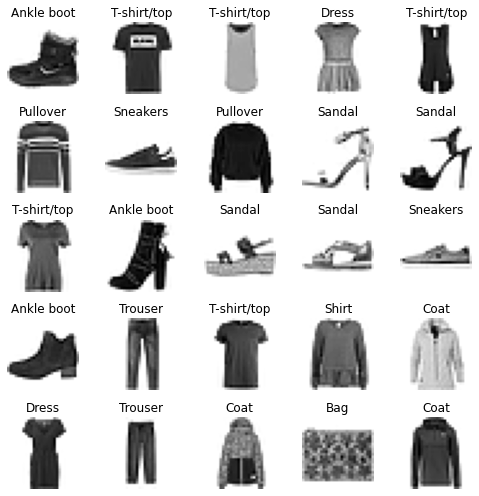

In [64]:
display(train_image,train_label,False,"")

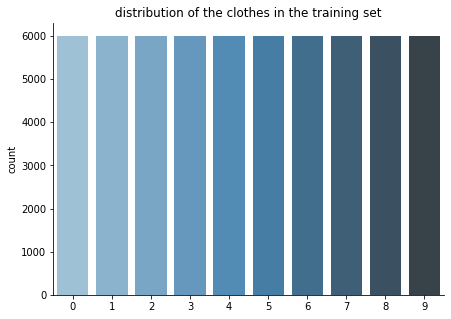

In [65]:
plt.figure(figsize=(7,5))
sns.countplot(x=train_label.astype(int),palette='Blues_d').set(title='distribution of the clothes in the training set')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

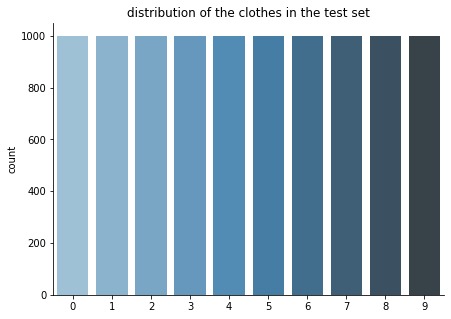

In [66]:
plt.figure(figsize=(7,5))
sns.countplot(x=test_label.astype(int),palette='Blues_d').set(title='distribution of the clothes in the test set')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

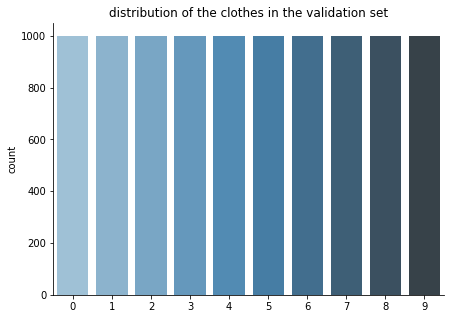

In [67]:
valid_image=[]
valid_label=[]
df=pd.Series(train_label)
classes=pd.Series(df).unique()

idx=[]

for i in classes:

    s = df[df == i].sample(1000)
    valid_label.extend(s)
    valid_image.extend(train_image[s.index])
    idx.extend(s.index)
valid_image=np.array(valid_image)
valid_label=np.array(valid_label)

plt.figure(figsize=(7,5))
sns.countplot(x=valid_label.astype(int),palette='Blues_d').set(title='distribution of the clothes in the validation set')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [68]:
train_image=np.delete(train_image, idx,axis=0)
train_label=np.delete(train_label, idx,axis=0)

# Shuffle validation data

In [69]:
from sklearn.utils import shuffle
valid_image, valid_label = shuffle(valid_image, valid_label, random_state=0)

In [70]:
print(train_image.shape , train_label.shape)
print(test_image.shape , test_label.shape)
print(valid_image.shape,valid_label.shape)

(50000, 28, 28, 1) (50000,)
(10000, 28, 28, 1) (10000,)
(10000, 28, 28, 1) (10000,)


# Converting the labels into one-hot vectors

In [71]:
train_label = to_categorical(train_label, num_classes = 10)
test_label = to_categorical(test_label, num_classes = 10)
valid_label = to_categorical(valid_label, num_classes = 10)

# Creating image generators for training and validation sets

In [72]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##data generator for training data
datagen_t = ImageDataGenerator(  
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1) 

##data generator for validation data
datagen_v = ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1)  

datagen_t.fit(train_image)
datagen_v.fit(valid_image)
###generating gray images
train_generator=datagen_t.flow(train_image,train_label,batch_size=32)
valid_generator=datagen_v.flow(valid_image,valid_label,batch_size=32)

# Model configuration :

In [73]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D

In [74]:
def model_config_1(train_x):

    input = Input(shape=train_x.shape[1:],name = 'input_layer' )
    x=Conv2D(64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_1')(input)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer1')(x)
    x=Dropout(0.1,name='D_O_of_layer1')(x)

    x=Conv2D(128, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_2')(x)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer2')(x)
    x=Dropout(0.1,name='D_O_of_layer2')(x)

    x=Conv2D(256, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_3')(x)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer3')(x)
    x=Dropout(0.1,name='D_O_of_layer3')(x)
    
    x =Flatten(name='flat_layer')(x)
    x=Dense(1024, activation = "relu",name='dense1')(x)
    x=Dropout(0.5,name='D_O_of_layer4')(x)

    x=Dense(512, activation = "relu",name='dense2')(x)
    x=Dropout(0.5,name='D_O_of_layer5')(x)
    
    x=Dense(128, activation = "relu",name='dense3')(x)
    x=Dropout(0.5,name='D_O_of_layer6')(x)

    output=Dense(10, activation = "softmax",name='output_layer')(x)
      
    model = Model(input, output)

    return model

In [75]:
model_config_1(train_image).summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv_layer_1 (Conv2D)       (None, 28, 28, 64)        640       
                                                                 
 M_P_of_layer1 (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 D_O_of_layer1 (Dropout)     (None, 14, 14, 64)        0         
                                                                 
 conv_layer_2 (Conv2D)       (None, 14, 14, 128)       73856     
                                                                 
 M_P_of_layer2 (MaxPooling2D  (None, 7, 7, 128)        0         
 )                                                         

In [76]:
step=len(train_label)//32
step_v=len(valid_label)//32


### creating a function for compiling the model's settings

def comp(model,lr,opt):
    if opt=='sgd':
        optimum=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    if opt=='adam':
        optimum=tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimum,loss='categorical_crossentropy', metrics=['accuracy'])
    
### creating a function for fitting the cnn model to data

def fit_model(model,train_generator,valid_generator , epoch):
    
        history =  model.fit(train_generator, epochs=epoch, validation_data=valid_generator, steps_per_epoch= step , validation_steps=step_v  )
        return history

In [77]:
def plot_model(history):
    df=pd.DataFrame(history.history)
    fig, axs = plt.subplots(1, 2,figsize=(15,5))
    axs[0].plot(df['val_loss'])
    axs[0].plot(df['loss'])
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['validation loss','training loss'], loc='upper right')
    axs[0].set_title('Loss of train/validation sets vs Epochs')
    axs[1].plot(df['val_accuracy'])
    axs[1].plot(df['accuracy'])
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('accuracy')
    axs[1].legend(['validation accuracy','training accuracy'], loc='lower right')
    axs[1].set_title('Accuracy of train/validation sets vs Epochs')
    plt.show()

# Begin Training : 

In [78]:
model_1=model_config_1(train_image)

comp(model_1,0.001,'adam')

history_1=fit_model(model_1,train_generator,valid_generator,20)

Epoch 1/20
1562/1562 [==============================] - 26s 16ms/step - loss: 0.7955 - accuracy: 0.6999 - val_loss: 0.4931 - val_accuracy: 0.8169
Epoch 2/20
1562/1562 [==============================] - 25s 16ms/step - loss: 0.5242 - accuracy: 0.8079 - val_loss: 0.4282 - val_accuracy: 0.8366
Epoch 3/20
1562/1562 [==============================] - 23s 15ms/step - loss: 0.4698 - accuracy: 0.8298 - val_loss: 0.3962 - val_accuracy: 0.8497
Epoch 4/20
1562/1562 [==============================] - 23s 14ms/step - loss: 0.4435 - accuracy: 0.8417 - val_loss: 0.3861 - val_accuracy: 0.8527
Epoch 5/20
1562/1562 [==============================] - 23s 15ms/step - loss: 0.4249 - accuracy: 0.8495 - val_loss: 0.3643 - val_accuracy: 0.8628
Epoch 6/20
1562/1562 [==============================] - 23s 14ms/step - loss: 0.4085 - accuracy: 0.8543 - val_loss: 0.3431 - val_accuracy: 0.8726
Epoch 7/20
1562/1562 [==============================] - 24s 15ms/step - loss: 0.3945 - accuracy: 0.8590 - val_loss: 0.3428 -

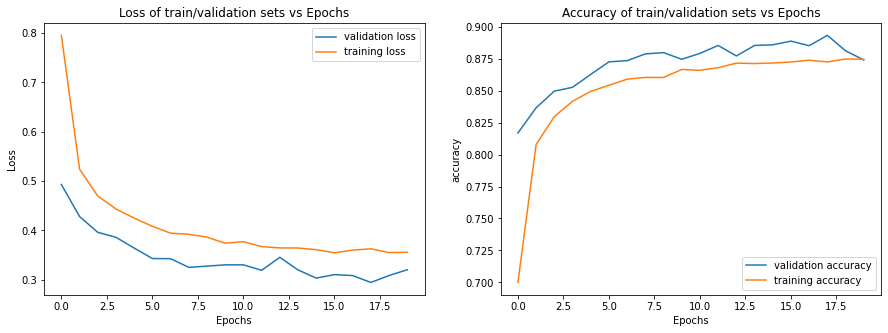

In [79]:
plot_model(history_1)

In [80]:
score = model_1.evaluate(test_image, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2980711758136749
Test accuracy: 0.885200023651123


In [81]:
def model_config_2(train_x):

    input = Input(shape=train_x.shape[1:],name = 'input_layer' )
    x=Conv2D(64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_1')(input)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer1')(x)
    x=Dropout(0.1,name='D_O_of_layer1')(x)

    x=Conv2D(128, kernel_size = (3,3),strides=(2,2), activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_2')(x)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer2')(x)
    x=Dropout(0.1,name='D_O_of_layer2')(x)

    x=Conv2D(256, kernel_size = (3,3), strides=(2,2), activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_3')(x)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer3')(x)
    x=Dropout(0.1,name='D_O_of_layer3')(x)
    
    x =Flatten(name='flat_layer')(x)
    x=Dense(128, activation = "relu",name='dense1')(x)
    x=Dropout(0.5,name='D_O_of_layer4')(x)

    x=Dense(256, activation = "relu",name='dense2')(x)
    x=Dropout(0.1,name='D_O_of_layer5')(x)

    x=Dense(128, activation = "relu",name='dense3')(x)
    x=Dropout(0.1,name='D_O_of_layer6')(x)

    output=Dense(10, activation = "softmax",name='output_layer')(x)
      
    model = Model(input, output)

    return model

In [82]:
model_config_2(train_image).summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv_layer_1 (Conv2D)       (None, 28, 28, 64)        640       
                                                                 
 M_P_of_layer1 (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 D_O_of_layer1 (Dropout)     (None, 14, 14, 64)        0         
                                                                 
 conv_layer_2 (Conv2D)       (None, 7, 7, 128)         73856     
                                                                 
 M_P_of_layer2 (MaxPooling2D  (None, 3, 3, 128)        0         
 )                                                         

In [83]:
model_2=model_config_2(train_image)

comp(model_2,0.001,'adam')

history_2=fit_model(model_2,train_generator,valid_generator,20)

Epoch 1/20
1562/1562 [==============================] - 22s 14ms/step - loss: 0.8304 - accuracy: 0.6805 - val_loss: 0.5501 - val_accuracy: 0.7793
Epoch 2/20
1562/1562 [==============================] - 22s 14ms/step - loss: 0.5769 - accuracy: 0.7807 - val_loss: 0.4914 - val_accuracy: 0.8092
Epoch 3/20
1562/1562 [==============================] - 22s 14ms/step - loss: 0.5271 - accuracy: 0.8014 - val_loss: 0.4654 - val_accuracy: 0.8242
Epoch 4/20
1562/1562 [==============================] - 21s 14ms/step - loss: 0.4858 - accuracy: 0.8194 - val_loss: 0.4634 - val_accuracy: 0.8240
Epoch 5/20
1562/1562 [==============================] - 24s 15ms/step - loss: 0.4608 - accuracy: 0.8292 - val_loss: 0.3997 - val_accuracy: 0.8508
Epoch 6/20
1562/1562 [==============================] - 22s 14ms/step - loss: 0.4484 - accuracy: 0.8349 - val_loss: 0.4023 - val_accuracy: 0.8490
Epoch 7/20
1562/1562 [==============================] - 25s 16ms/step - loss: 0.4344 - accuracy: 0.8401 - val_loss: 0.4071 -

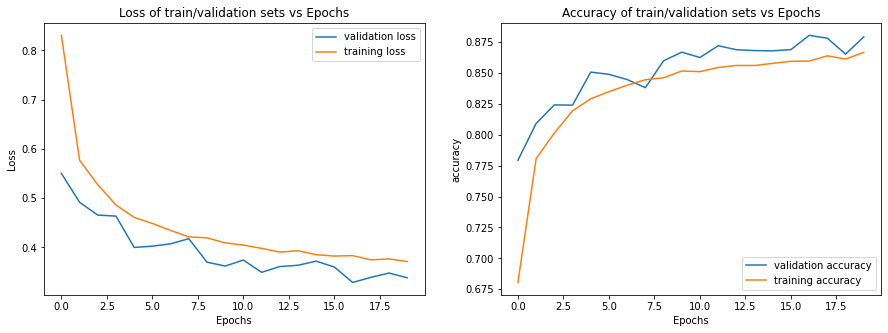

In [84]:
plot_model(history_2)

In [85]:
score = model_2.evaluate(test_image, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.30812710523605347
Test accuracy: 0.8896999955177307


In [86]:
def model_config_3(train_x):

    input = Input(shape=train_x.shape[1:],name = 'input_layer' )
    x=Conv2D(32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_1')(input)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer1')(x)
    x=Dropout(0.1,name='D_O_of_layer1')(x)

    x=Conv2D(64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_2')(x)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer2')(x)
    x=Dropout(0.1,name='D_O_of_layer2')(x)

    x=Conv2D(128, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_3')(x)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer3')(x)
    x=Dropout(0.1,name='D_O_of_layer3')(x)
    
    x =Flatten(name='flat_layer')(x)
    x=Dense(512, activation = "relu",name='dense1')(x)
    x=Dropout(0.3,name='D_O_of_layer4')(x)

    x=Dense(256, activation = "relu",name='dense2')(x)
    x=Dropout(0.1,name='D_O_of_layer5')(x)

    x=Dense(128, activation = "relu",name='dense3')(x)
    x=Dropout(0.1,name='D_O_of_layer6')(x)

    output=Dense(10, activation = "softmax",name='output_layer')(x)
      
    model = Model(input, output)

    return model

In [87]:
model_config_3(train_image).summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv_layer_1 (Conv2D)       (None, 28, 28, 32)        320       
                                                                 
 M_P_of_layer1 (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 D_O_of_layer1 (Dropout)     (None, 14, 14, 32)        0         
                                                                 
 conv_layer_2 (Conv2D)       (None, 14, 14, 64)        18496     
                                                                 
 M_P_of_layer2 (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                        

In [88]:
model_3=model_config_3(train_image)

comp(model_3,0.001,'adam')

history_3=fit_model(model_3,train_generator,valid_generator,20)

Epoch 1/20
1562/1562 [==============================] - 22s 14ms/step - loss: 0.7016 - accuracy: 0.7294 - val_loss: 0.5160 - val_accuracy: 0.8010
Epoch 2/20
1562/1562 [==============================] - 22s 14ms/step - loss: 0.4796 - accuracy: 0.8189 - val_loss: 0.4083 - val_accuracy: 0.8438
Epoch 3/20
1562/1562 [==============================] - 21s 14ms/step - loss: 0.4188 - accuracy: 0.8426 - val_loss: 0.3964 - val_accuracy: 0.8495
Epoch 4/20
1562/1562 [==============================] - 21s 13ms/step - loss: 0.3918 - accuracy: 0.8538 - val_loss: 0.3451 - val_accuracy: 0.8689
Epoch 5/20
1562/1562 [==============================] - 21s 14ms/step - loss: 0.3728 - accuracy: 0.8596 - val_loss: 0.3375 - val_accuracy: 0.8732
Epoch 6/20
1562/1562 [==============================] - 24s 15ms/step - loss: 0.3552 - accuracy: 0.8663 - val_loss: 0.3115 - val_accuracy: 0.8830
Epoch 7/20
1562/1562 [==============================] - 23s 15ms/step - loss: 0.3421 - accuracy: 0.8717 - val_loss: 0.3406 -

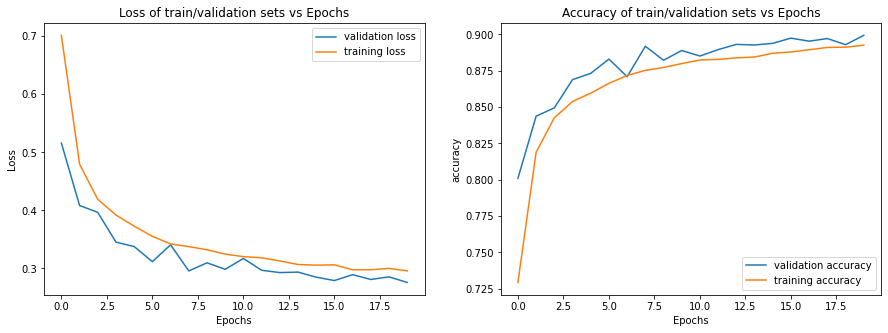

In [89]:
plot_model(history_3)

In [90]:
score = model_3.evaluate(test_image, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2557733654975891
Test accuracy: 0.9075000286102295


In [91]:
model_4=model_config_3(train_image)

comp(model_4,0.001,'adam')

history_4=fit_model(model_4,train_generator,valid_generator,50)

Epoch 1/50
1562/1562 [==============================] - 22s 14ms/step - loss: 0.6815 - accuracy: 0.7400 - val_loss: 0.5107 - val_accuracy: 0.8077
Epoch 2/50
1562/1562 [==============================] - 24s 15ms/step - loss: 0.4758 - accuracy: 0.8217 - val_loss: 0.4128 - val_accuracy: 0.8420
Epoch 3/50
1562/1562 [==============================] - 24s 15ms/step - loss: 0.4175 - accuracy: 0.8440 - val_loss: 0.3729 - val_accuracy: 0.8585
Epoch 4/50
1562/1562 [==============================] - 24s 15ms/step - loss: 0.3916 - accuracy: 0.8515 - val_loss: 0.3598 - val_accuracy: 0.8673
Epoch 5/50
1562/1562 [==============================] - 22s 14ms/step - loss: 0.3715 - accuracy: 0.8608 - val_loss: 0.3666 - val_accuracy: 0.8611
Epoch 6/50
1562/1562 [==============================] - 24s 15ms/step - loss: 0.3575 - accuracy: 0.8677 - val_loss: 0.3653 - val_accuracy: 0.8638
Epoch 7/50
1562/1562 [==============================] - 24s 15ms/step - loss: 0.3488 - accuracy: 0.8710 - val_loss: 0.3231 -

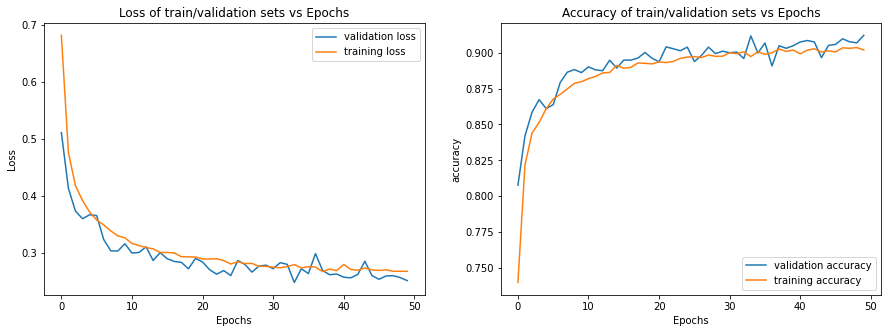

In [92]:
plot_model(history_4)

In [93]:
score = model_4.evaluate(test_image, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.25349950790405273
Test accuracy: 0.9132999777793884


In [94]:
def model_config_4(train_x):

    input = Input(shape=train_x.shape[1:],name = 'input_layer' )
    x=Conv2D(32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_1')(input)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer1')(x)

    x=Conv2D(64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_2')(x)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer2')(x)
    x=Dropout(0.1,name='D_O_of_layer2')(x)

    x=Conv2D(128, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_3')(x)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer3')(x)
    x=Dropout(0.1,name='D_O_of_layer3')(x)
    
    x =Flatten(name='flat_layer')(x)
    x=Dense(512, activation = "relu",name='dense1')(x)
    x=Dropout(0.3,name='D_O_of_layer4')(x)

    x=Dense(256, activation = "relu",name='dense2')(x)
    x=Dropout(0.1,name='D_O_of_layer5')(x)

    x=Dense(128, activation = "relu",name='dense3')(x)

    output=Dense(10, activation = "softmax",name='output_layer')(x)
      
    model = Model(input, output)

    return model

In [95]:
model_config_4(train_image).summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv_layer_1 (Conv2D)       (None, 28, 28, 32)        320       
                                                                 
 M_P_of_layer1 (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv_layer_2 (Conv2D)       (None, 14, 14, 64)        18496     
                                                                 
 M_P_of_layer2 (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 D_O_of_layer2 (Dropout)     (None, 7, 7, 64)          0  

In [96]:
model_5=model_config_4(train_image)

comp(model_5,0.001,'sgd')

history_5=fit_model(model_5,train_generator,valid_generator,30)

Epoch 1/30
1562/1562 [==============================] - 24s 15ms/step - loss: 1.3919 - accuracy: 0.4748 - val_loss: 0.8424 - val_accuracy: 0.6830
Epoch 2/30
1562/1562 [==============================] - 23s 15ms/step - loss: 0.8305 - accuracy: 0.6809 - val_loss: 0.7064 - val_accuracy: 0.7274
Epoch 3/30
1562/1562 [==============================] - 23s 15ms/step - loss: 0.7187 - accuracy: 0.7209 - val_loss: 0.6362 - val_accuracy: 0.7538
Epoch 4/30
1562/1562 [==============================] - 21s 14ms/step - loss: 0.6606 - accuracy: 0.7476 - val_loss: 0.5941 - val_accuracy: 0.7673
Epoch 5/30
1562/1562 [==============================] - 21s 13ms/step - loss: 0.6185 - accuracy: 0.7631 - val_loss: 0.5489 - val_accuracy: 0.7905
Epoch 6/30
1562/1562 [==============================] - 21s 13ms/step - loss: 0.5869 - accuracy: 0.7762 - val_loss: 0.5159 - val_accuracy: 0.8019
Epoch 7/30
1562/1562 [==============================] - 21s 13ms/step - loss: 0.5585 - accuracy: 0.7863 - val_loss: 0.5175 -

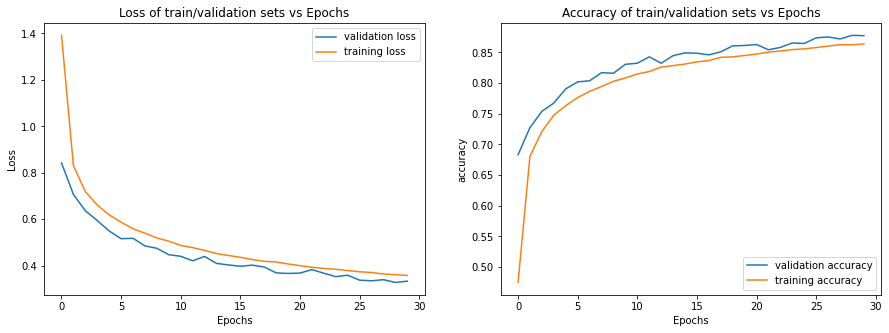

In [97]:
plot_model(history_5)

In [98]:
score = model_5.evaluate(test_image, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.30280622839927673
Test accuracy: 0.8870999813079834


In [99]:
model_6=model_config_4(train_image)

comp(model_6,0.001,'adam')

history_6=fit_model(model_6,train_generator,valid_generator,30)

Epoch 1/30
1562/1562 [==============================] - 24s 15ms/step - loss: 0.6666 - accuracy: 0.7422 - val_loss: 0.4591 - val_accuracy: 0.8256
Epoch 2/30
1562/1562 [==============================] - 21s 13ms/step - loss: 0.4577 - accuracy: 0.8249 - val_loss: 0.3981 - val_accuracy: 0.8508
Epoch 3/30
1562/1562 [==============================] - 24s 15ms/step - loss: 0.3995 - accuracy: 0.8483 - val_loss: 0.3904 - val_accuracy: 0.8529
Epoch 4/30
1562/1562 [==============================] - 23s 15ms/step - loss: 0.3757 - accuracy: 0.8582 - val_loss: 0.3523 - val_accuracy: 0.8690
Epoch 5/30
1562/1562 [==============================] - 21s 13ms/step - loss: 0.3543 - accuracy: 0.8660 - val_loss: 0.3492 - val_accuracy: 0.8690
Epoch 6/30
1562/1562 [==============================] - 22s 14ms/step - loss: 0.3382 - accuracy: 0.8727 - val_loss: 0.3204 - val_accuracy: 0.8775
Epoch 7/30
1562/1562 [==============================] - 23s 15ms/step - loss: 0.3295 - accuracy: 0.8767 - val_loss: 0.3482 -

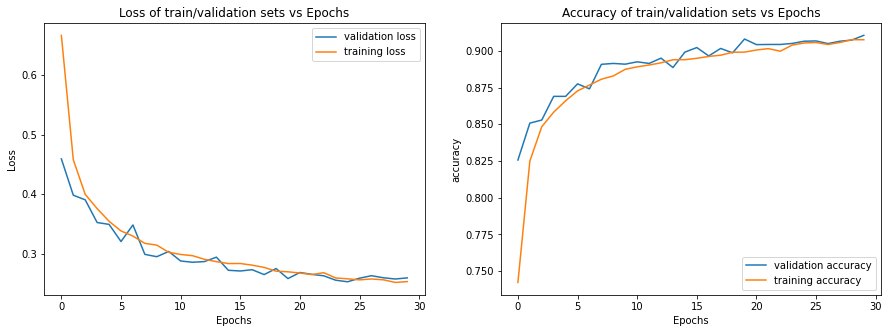

In [100]:
plot_model(history_6)

In [101]:
score = model_6.evaluate(test_image, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.245987668633461
Test accuracy: 0.913100004196167


In [102]:
def model_config_5(train_x):

    input = Input(shape=train_x.shape[1:],name = 'input_layer' )
    x = BatchNormalization()(input)
    x=Conv2D(32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_1')(input)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer1')(x)
    x = Dropout(0.3)(x)

    x = BatchNormalization()(x)
    x=Conv2D(64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_2')(x)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer2')(x)
    x=Dropout(0.3,name='D_O_of_layer2')(x)

    x=Conv2D(128, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_3')(x)
    x=Conv2D(128, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_4')(x)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer3')(x)
    x=Dropout(0.3,name='D_O_of_layer3')(x)
    
    x = BatchNormalization()(x)
    x = Flatten(name='flat_layer')(x)

    x=Dense(256, activation = "relu",name='dense2')(x)
    x=Dropout(0.1,name='D_O_of_layer5')(x)

    x=Dense(128, activation = "relu",name='dense3')(x)

    output=Dense(10, activation = "softmax",name='output_layer')(x)
      
    model = Model(input, output)

    return model

In [103]:
model_config_5(train_image).summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv_layer_1 (Conv2D)       (None, 28, 28, 32)        320       
                                                                 
 M_P_of_layer1 (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 conv_layer_2 (Conv2D)       (None, 14, 14, 64)        184

In [104]:
model_7=model_config_5(train_image)

comp(model_7,0.001,'adam')

history_7=fit_model(model_7,train_generator,valid_generator,50)

Epoch 1/50
1562/1562 [==============================] - 25s 15ms/step - loss: 0.6760 - accuracy: 0.7385 - val_loss: 0.4783 - val_accuracy: 0.8175
Epoch 2/50
1562/1562 [==============================] - 24s 16ms/step - loss: 0.4888 - accuracy: 0.8126 - val_loss: 0.4303 - val_accuracy: 0.8279
Epoch 3/50
1562/1562 [==============================] - 21s 14ms/step - loss: 0.4375 - accuracy: 0.8364 - val_loss: 0.3682 - val_accuracy: 0.8602
Epoch 4/50
1562/1562 [==============================] - 21s 14ms/step - loss: 0.4115 - accuracy: 0.8444 - val_loss: 0.3903 - val_accuracy: 0.8563
Epoch 5/50
1562/1562 [==============================] - 22s 14ms/step - loss: 0.3894 - accuracy: 0.8509 - val_loss: 0.3301 - val_accuracy: 0.8769
Epoch 6/50
1562/1562 [==============================] - 21s 14ms/step - loss: 0.3754 - accuracy: 0.8585 - val_loss: 0.3494 - val_accuracy: 0.8637
Epoch 7/50
1562/1562 [==============================] - 24s 15ms/step - loss: 0.3667 - accuracy: 0.8610 - val_loss: 0.3211 -

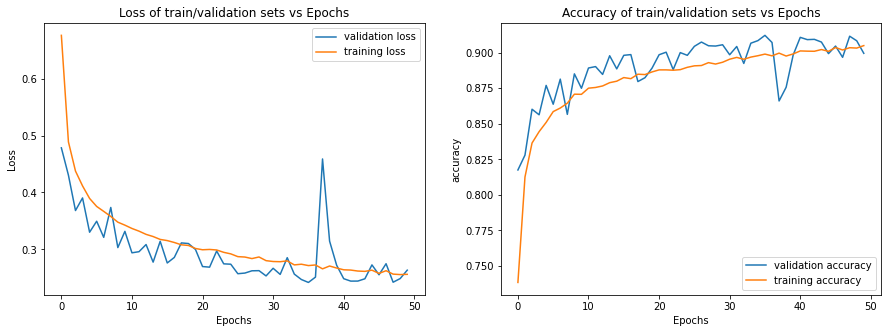

In [105]:
plot_model(history_7)

In [106]:
score = model_7.evaluate(test_image, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.27942779660224915
Test accuracy: 0.8898000121116638


In [107]:
def model_config_6(train_x):

    input = Input(shape=train_x.shape[1:],name = 'input_layer' )
    x=Conv2D(32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_1')(input)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer1')(x)

    x=Conv2D(64, kernel_size = (3,3), activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_2')(x)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer2')(x)
    x=Dropout(0.3,name='D_O_of_layer2')(x)

    x=Conv2D(128, kernel_size = (3,3), activation ='relu', input_shape =train_x.shape[1:],name = 'conv_layer_3')(x)
    x=MaxPool2D(pool_size=(2,2), strides=(2,2),name='M_P_of_layer3')(x)
    x=Dropout(0.1,name='D_O_of_layer3')(x)
    
    x = Flatten(name='flat_layer')(x)

    x=Dense(256, activation = "relu",name='dense2')(x)
    x=Dropout(0.1,name='D_O_of_layer5')(x)

    x=Dense(128, activation = "relu",name='dense3')(x)

    output=Dense(10, activation = "softmax",name='output_layer')(x)
      
    model = Model(input, output)

    return model

In [108]:
model_config_6(train_image).summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv_layer_1 (Conv2D)       (None, 28, 28, 32)        320       
                                                                 
 M_P_of_layer1 (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv_layer_2 (Conv2D)       (None, 12, 12, 64)        18496     
                                                                 
 M_P_of_layer2 (MaxPooling2D  (None, 6, 6, 64)         0         
 )                                                               
                                                                 
 D_O_of_layer2 (Dropout)     (None, 6, 6, 64)          0  

In [109]:
model_8=model_config_6(train_image)

comp(model_8,0.001,'adam')

history_8=fit_model(model_8,train_generator,valid_generator,30)

Epoch 1/30
1562/1562 [==============================] - 22s 13ms/step - loss: 0.7083 - accuracy: 0.7291 - val_loss: 0.5008 - val_accuracy: 0.8030
Epoch 2/30
1562/1562 [==============================] - 23s 15ms/step - loss: 0.4995 - accuracy: 0.8094 - val_loss: 0.4351 - val_accuracy: 0.8294
Epoch 3/30
1562/1562 [==============================] - 23s 14ms/step - loss: 0.4324 - accuracy: 0.8334 - val_loss: 0.3757 - val_accuracy: 0.8565
Epoch 4/30
1562/1562 [==============================] - 20s 13ms/step - loss: 0.3966 - accuracy: 0.8504 - val_loss: 0.3932 - val_accuracy: 0.8540
Epoch 5/30
1562/1562 [==============================] - 23s 15ms/step - loss: 0.3769 - accuracy: 0.8576 - val_loss: 0.3542 - val_accuracy: 0.8664
Epoch 6/30
1562/1562 [==============================] - 23s 15ms/step - loss: 0.3580 - accuracy: 0.8631 - val_loss: 0.3218 - val_accuracy: 0.8785
Epoch 7/30
1562/1562 [==============================] - 21s 13ms/step - loss: 0.3479 - accuracy: 0.8684 - val_loss: 0.3219 -

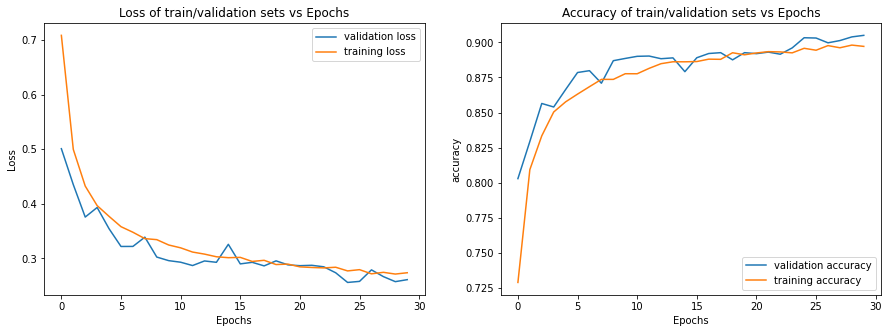

In [110]:
plot_model(history_8)

In [111]:
score = model_8.evaluate(test_image, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2408902794122696
Test accuracy: 0.9121000170707703


In [125]:
pred8=model_8.predict(test_image)

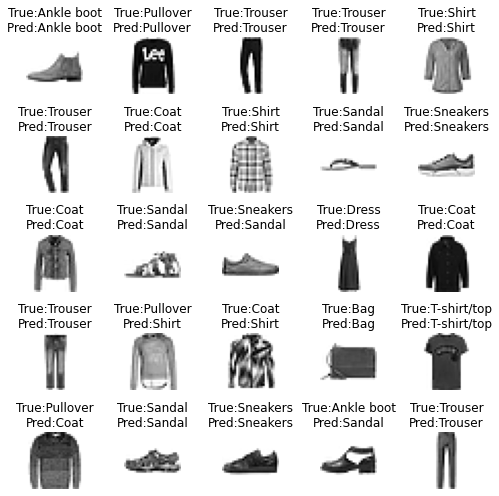

In [126]:
display(test_image,np.argmax(test_label,axis=1),True,np.argmax(pred7,axis=1))

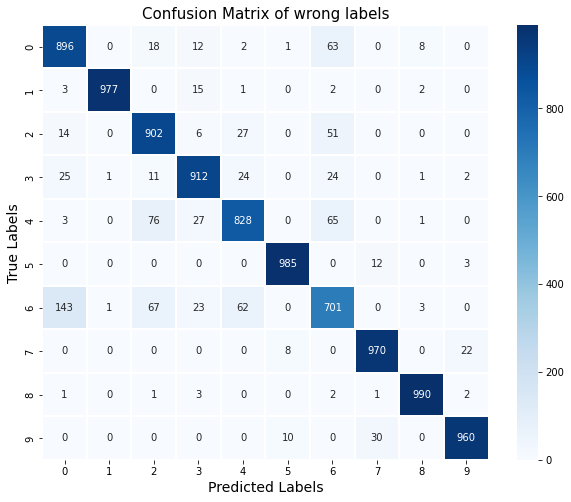

In [127]:
cm = pd.DataFrame(confusion_matrix(np.argmax(test_label,axis=1), np.argmax(pred8,axis=1)) )
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True,fmt="d")
plt.title('Confusion Matrix of wrong labels', size=15)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('True Labels', size=14)
plt.show()

|label |name|
|:-----:|--------|
|0|T-shirt/top|
|1  |Trouser|
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneakers|
|8|Bag|
|9|Ankle boot|

In [115]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet_model = ResNet50(classes=10, weights=None, input_shape=(32, 32, 1))

In [116]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 1)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [117]:
res_test_image= tf.image.resize(test_image, [32,32])
res_train_image= tf.image.resize(train_image, [32,32])
res_valid_image= tf.image.resize(valid_image, [32,32])

In [118]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##data generator for training data
datagen_t = ImageDataGenerator(  
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1) 

##data generator for validation data
datagen_v = ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1)  

datagen_t.fit(res_train_image)
datagen_v.fit(res_valid_image)
###generating gray images
res_train_generator=datagen_t.flow(res_train_image,train_label,batch_size=32)
res_valid_generator=datagen_v.flow(res_valid_image,valid_label,batch_size=32)

In [119]:
resnet_model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [120]:
step=len(train_label)//32
step_v=len(valid_label)//32
res_history = resnet_model.fit(res_train_generator, epochs=50,validation_data=res_valid_generator, steps_per_epoch= step , validation_steps=step_v )

Epoch 1/50
1562/1562 [==============================] - 81s 48ms/step - loss: 1.1315 - accuracy: 0.6603 - val_loss: 1.0914 - val_accuracy: 0.6488
Epoch 2/50
1562/1562 [==============================] - 72s 46ms/step - loss: 0.7783 - accuracy: 0.7389 - val_loss: 0.5556 - val_accuracy: 0.7867
Epoch 3/50
1562/1562 [==============================] - 74s 47ms/step - loss: 1.0616 - accuracy: 0.6923 - val_loss: 1.7844 - val_accuracy: 0.7063
Epoch 4/50
1562/1562 [==============================] - 73s 47ms/step - loss: 0.7831 - accuracy: 0.7493 - val_loss: 1.3153 - val_accuracy: 0.7595
Epoch 5/50
1562/1562 [==============================] - 73s 47ms/step - loss: 0.7925 - accuracy: 0.7360 - val_loss: 0.5887 - val_accuracy: 0.7675
Epoch 6/50
1562/1562 [==============================] - 73s 47ms/step - loss: 0.7375 - accuracy: 0.7403 - val_loss: 0.7418 - val_accuracy: 0.7227
Epoch 7/50
1562/1562 [==============================] - 73s 46ms/step - loss: 0.6814 - accuracy: 0.7564 - val_loss: 0.5343 -

In [121]:
res_score = resnet_model.evaluate(res_test_image, test_label, verbose=0)
print('ResNet Test loss:', res_score[0])
print('ResNet Test accuracy:', res_score[1])

ResNet Test loss: 0.32922932505607605
ResNet Test accuracy: 0.8902000188827515


In [122]:
res_pred=resnet_model.predict(res_test_image)

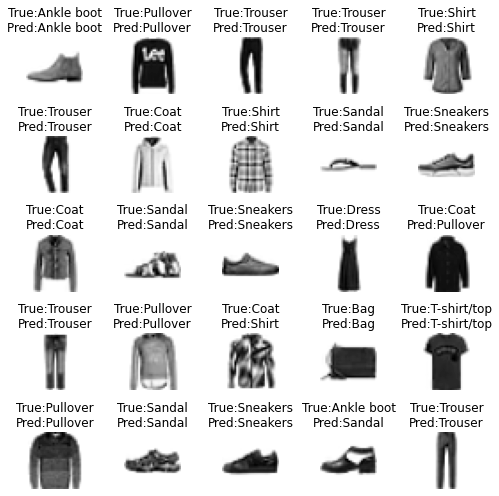

In [123]:
display(res_test_image,np.argmax(test_label,axis=1),True,np.argmax(res_pred,axis=1))

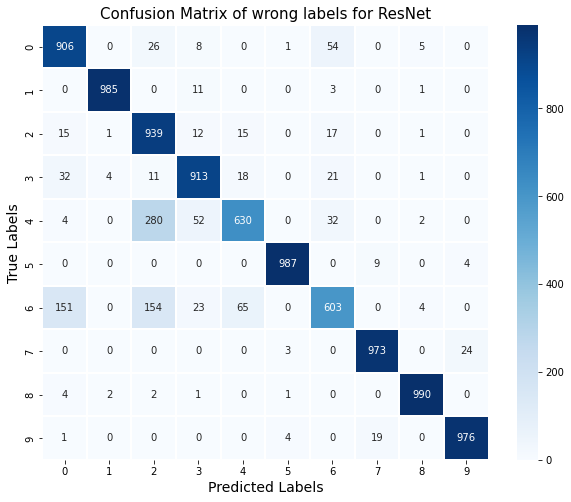

In [124]:
cm = pd.DataFrame(confusion_matrix(np.argmax(test_label,axis=1), np.argmax(res_pred,axis=1)) )
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True,fmt="d")
plt.title('Confusion Matrix of wrong labels for ResNet', size=15)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('True Labels', size=14)
plt.show()